<a href="https://colab.research.google.com/github/BJToor/sep769-deep-learning-project/blob/adam/DeepLearningProject_Group2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Project** - Aerial Perspective Object Detection
SEP 769 - Group 2

In [2]:

#About semantic segmentation: https://www.jeremyjordan.me/semantic-segmentation/
#TF Tutorial: https://www.tensorflow.org/tutorials/images/segmentation
#TF load and process images: https://www.tensorflow.org/tutorials/load_data/images

from google.colab import drive
import tensorflow as tf
import tensorflow_datasets as tfds
drive.mount('/content/gdrive')
import cv2
import glob
import numpy as np
import os
import fnmatch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

if not os.path.exists("/content/gdrive/Shareddrives/SEP_769/data/drone_data/"):
  !unzip "/content/gdrive/Shareddrives/SEP_769/drone_data.zip" -d "/content/gdrive/Shareddrives/SEP_769/data"

Mounted at /content/gdrive


#Constants

In [3]:
original_images_path = '/content/gdrive/Shareddrives/SEP_769/data/drone_data/original_images/'
original_semantic_path = '/content/gdrive/Shareddrives/SEP_769/data/drone_data/label_images_semantic/'
HEIGHT = 192
WIDTH = 320

In [4]:
# reads images from dir, resizes and returns np array
# optional file type argument ext
def images_to_array(dir, width, height, ext='.jpg'):
  data = []
  files = os.listdir(dir)
  files.sort()
  for filename in files:
    if filename.endswith(ext):
      img = cv2.imread(dir + filename)
      img = cv2.resize(img, (width, height))
      data.append(img)

  return np.array(data)

In [80]:
# displays a number of originals with their masks
def display_images(images):
  plt.figure(figsize=(15,10))
  for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    if len(images[i].shape) == 3 and images[i].shape[2] > 1:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]))
    else:
      # plt.imshow(images[i], cmap="gray", vmin=0, vmax=255)
      plt.imshow(images[i], cmap="gray")
  plt.show()

# Image Imports

In [6]:
images = images_to_array(original_images_path, width=WIDTH, height=HEIGHT)
print(images.shape)

(400, 192, 320, 3)


In [7]:
labels = images_to_array(original_semantic_path, width=WIDTH, height=HEIGHT, ext='png')
print(labels.shape)
labels = labels[:,:,:,1]
print(labels.shape)

(400, 192, 320, 3)
(400, 192, 320)


#Data Exploration

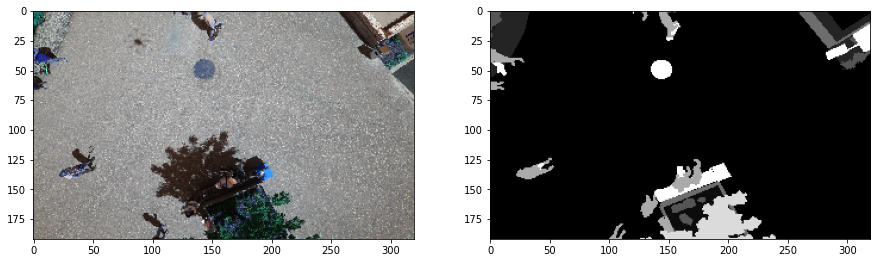

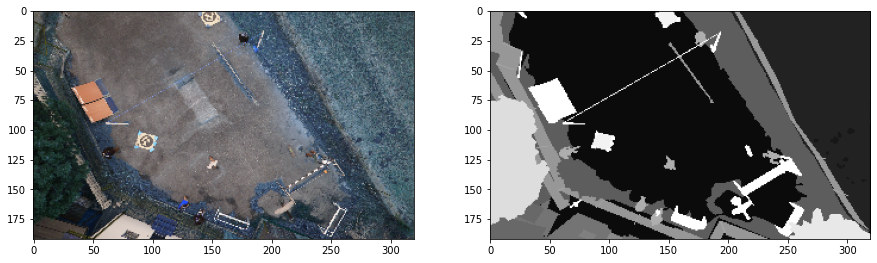

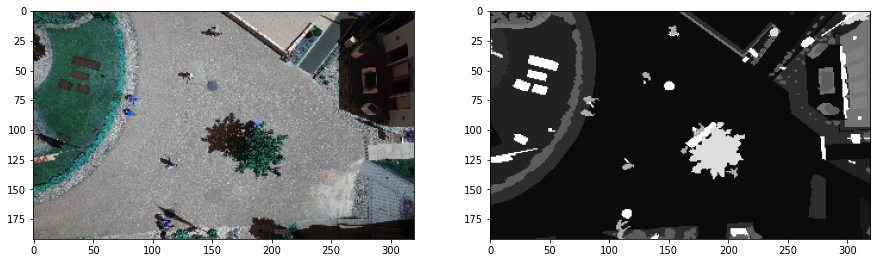

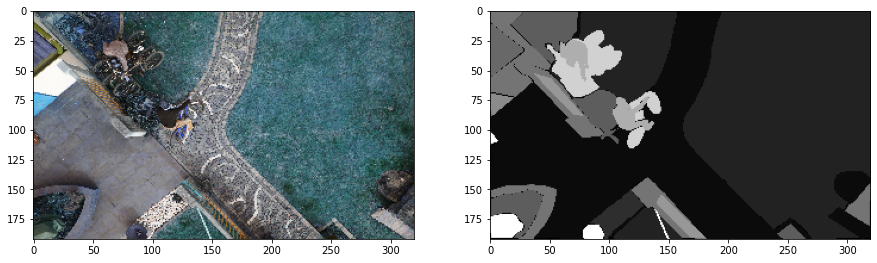

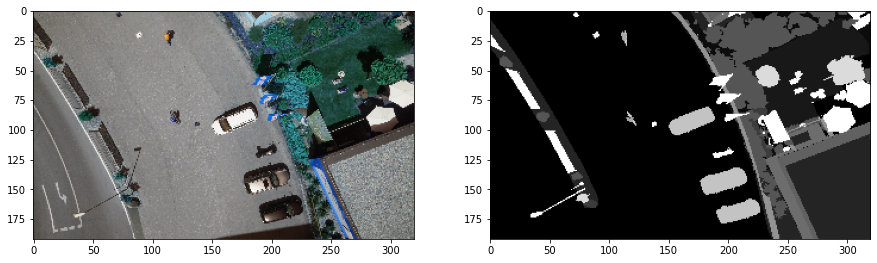

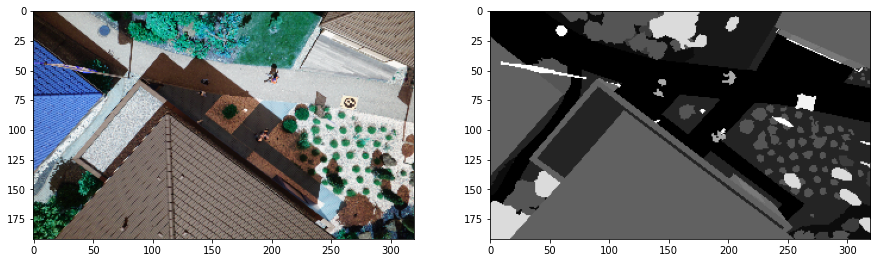

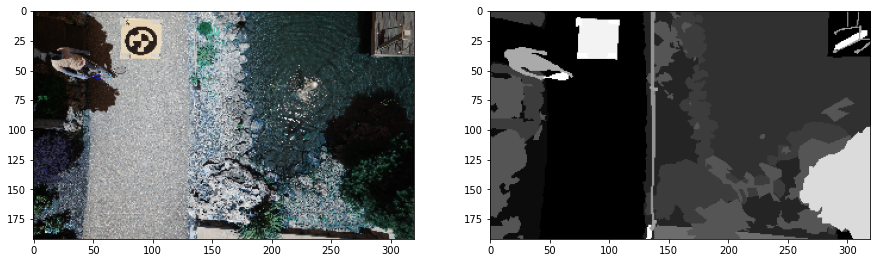

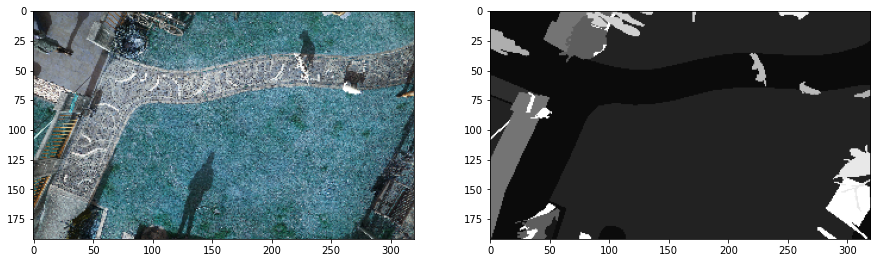

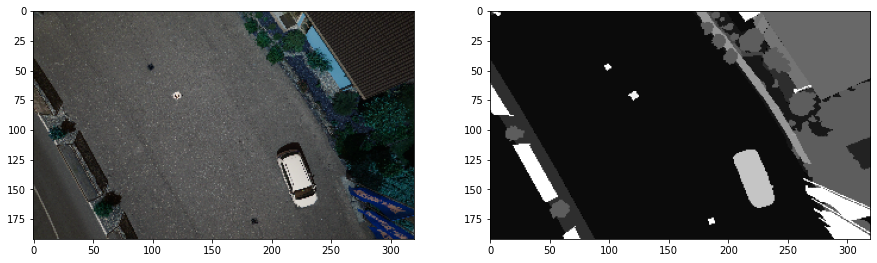

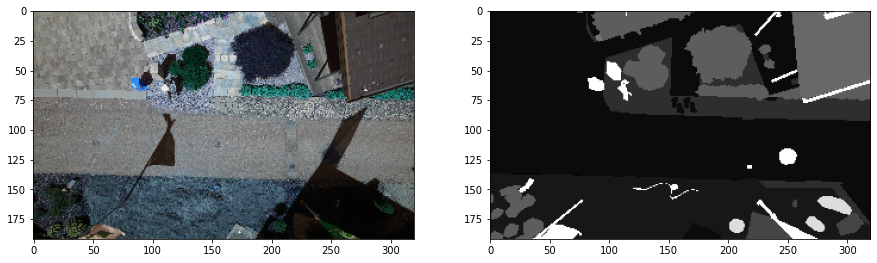

In [81]:
for i in range(10):
  display_images([images[i], labels[i]])

#Train Test Validation

In [9]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1)
X_train, X_val, Y_train, Y_val, = train_test_split(x_train, y_train, test_size=0.2)
X_train = X_train / 255.0
x_test = x_test / 255.0
X_val = X_val / 255.0

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(x_test.shape)
print(y_test.shape)


(288, 192, 320, 3)
(288, 192, 320)
(72, 192, 320, 3)
(72, 192, 320)
(40, 192, 320, 3)
(40, 192, 320)


#Model Development

In [10]:
# model_input = tf.keras.Input(shape=(X_train[0].shape))
model_input = tf.keras.Input(shape=(192,320,3))
transfer_model = tf.keras.applications.VGG16(include_top=False, input_tensor=model_input, weights="imagenet")
transfer_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [11]:
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 160, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 160, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 160, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 80, 128)       0     

In [13]:
encoder_layers = [
               "block1_pool",
               "block2_pool",
               "block3_pool",
               "block4_pool",
               "block5_pool"
]

encoder_layers = [transfer_model.get_layer(name).output for name in encoder_layers]
encoder = tf.keras.Model(inputs=transfer_model.input, outputs=encoder_layers)
encoder.trainable = False

decoder_layers = [tf.keras.layers.UpSampling2D(size=(2,2)) for i in range(len(encoder_layers))]

In [18]:
def build_model():
  # inputs = tf.keras.Input(shape=X_train[0].shape)
  inputs = tf.keras.Input(shape=(192,320,3))
  x = inputs

  skips = encoder(x)
  x = skips[-1]
  print(x)
  skips = reversed(skips[:-1])

  for i, skip in zip(decoder_layers, skips):
    x = i(x)
    concat = tf.keras.layers.Concatenate()
    print(x.shape)
    print(skip.shape)
    print("concatenating...")
    x = concat([x, skip])
  
  last = tf.keras.layers.Convolution2DTranspose(23,3,strides=2,padding='same')
  x = last(x)
  model = tf.keras.Model(inputs=inputs, outputs=x)
  model.summary()
  return model

In [19]:
segmentation_model = build_model()
segmentation_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 10, 512), dtype=tf.float32, name=None), name='model/block5_pool/MaxPool:0', description="created by layer 'model'")
(None, 12, 20, 512)
(None, 12, 20, 512)
concatenating...
(None, 24, 40, 1024)
(None, 24, 40, 256)
concatenating...
(None, 48, 80, 1280)
(None, 48, 80, 128)
concatenating...
(None, 96, 160, 1408)
(None, 96, 160, 64)
concatenating...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 320, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 96, 160, 64) 14714688    input_3[0][0]                    
___________________________________________________________________________________________

In [20]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
segmentation_model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

In [21]:
hist = segmentation_model.fit(X_train, Y_train, batch_size=6, epochs=25, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/25
48/48 [==============================] - 7s 133ms/step - loss: 2.9809 - accuracy: 0.4632 - val_loss: 1.6571 - val_accuracy: 0.5977
Epoch 2/25
48/48 [==============================] - 6s 128ms/step - loss: 1.4626 - accuracy: 0.6146 - val_loss: 1.3817 - val_accuracy: 0.6464
Epoch 3/25
48/48 [==============================] - 6s 135ms/step - loss: 1.2496 - accuracy: 0.6520 - val_loss: 1.3178 - val_accuracy: 0.6423
Epoch 4/25
48/48 [==============================] - 6s 131ms/step - loss: 1.1567 - accuracy: 0.6797 - val_loss: 1.2636 - val_accuracy: 0.6414
Epoch 5/25
48/48 [==============================] - 6s 132ms/step - loss: 1.0680 - accuracy: 0.6944 - val_loss: 1.1116 - val_accuracy: 0.6986
Epoch 6/25
48/48 [==============================] - 6s 133ms/step - loss: 1.0686 - accuracy: 0.6944 - val_loss: 1.1168 - val_accuracy: 0.6957
Epoch 7/25
48/48 [==============================] - 7s 140ms/step - loss: 1.0138 - accuracy: 0.7134 - val_loss: 1.0498 - val_accuracy: 0.7038
Epoch 

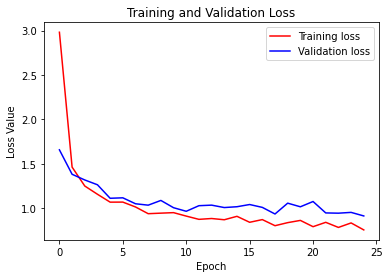

In [22]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(25)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

(192, 320, 3)
(192, 320)
(192, 320, 23)
[[3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 [3 3 3 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
19


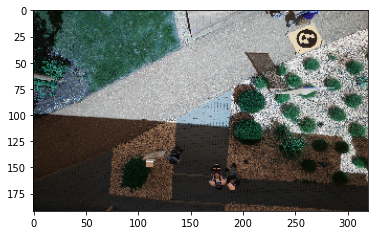

In [42]:
print(x_test[0].shape)
predictions = segmentation_model.predict(x_test)
print(y_test[0].shape)
print(predictions[0].shape)
print(y_test[0])
print(np.argmax(predictions[0,0,0,:], axis=-1))
# print(predictions[0].shape)
# print(np.unique(predictions[0,:,:,0]))
# for i in range(5):
#   print(len(predictions[i].shape))
#   print(predictions[i].shape)
#   display_images([x_test[i], predictions[i]])
plt.imshow(x_test[0])


In [43]:
def create_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask = mask[..., np.newaxis]
  return mask

In [74]:
predictions_processed = np.array([create_mask(predictions[i]) for i in range(len(predictions))])

(192, 320, 1)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22]


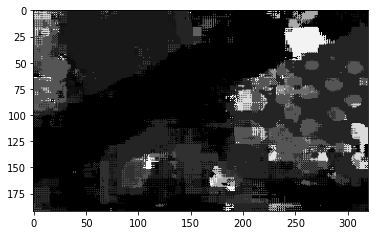

In [82]:
prediction_converted = create_mask(predictions[0])
print(prediction_converted.shape)
print(np.unique(prediction_converted))
plt.imshow(prediction_converted[:,:,0], cmap='gray')

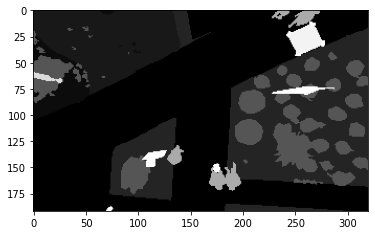

In [83]:
plt.imshow(y_test[0], cmap='gray')

In [84]:
print(predictions_processed.shape)
print(np.squeeze(predictions_processed).shape)
predictions_processed = np.squeeze(predictions_processed)

(40, 192, 320)
(40, 192, 320)


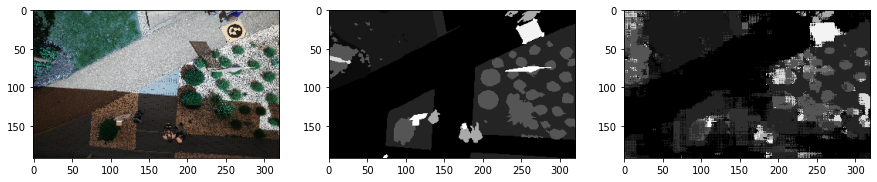

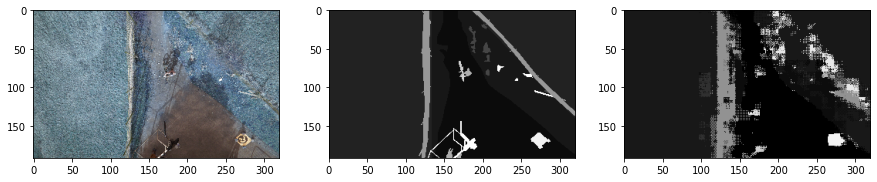

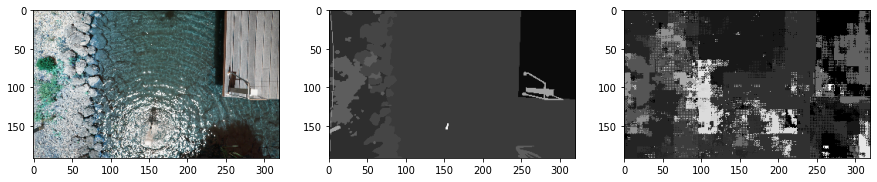

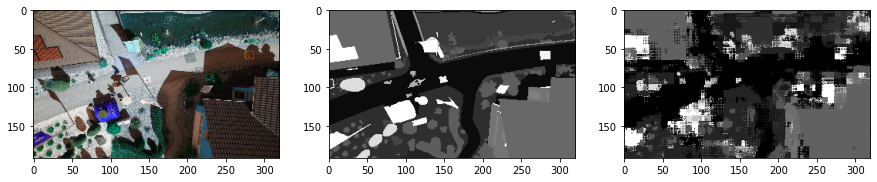

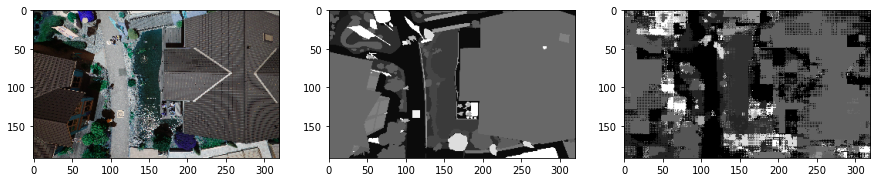

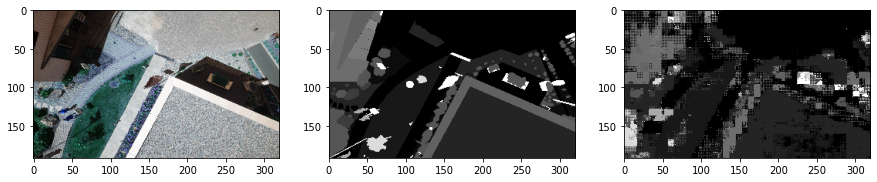

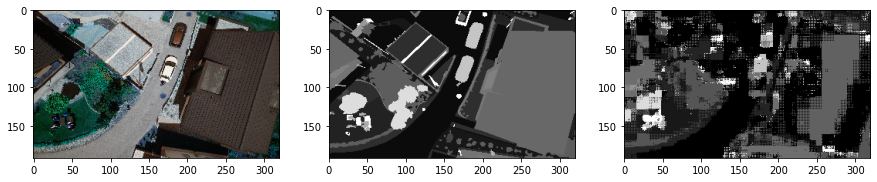

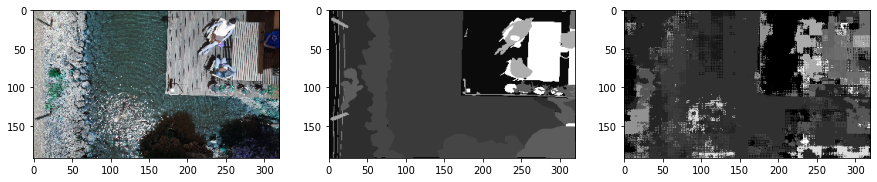

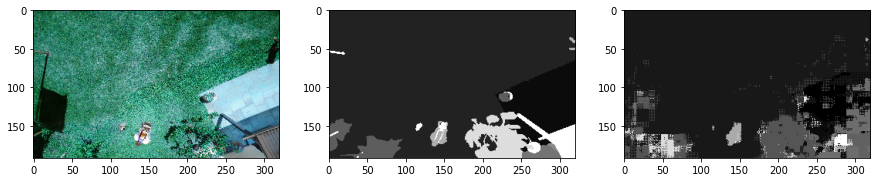

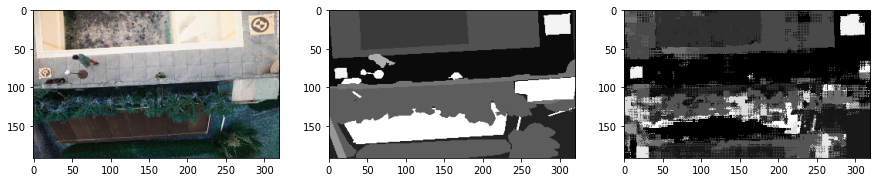

In [85]:
for i in range(10):
  display_images([x_test[i], y_test[i], predictions_processed[i]])

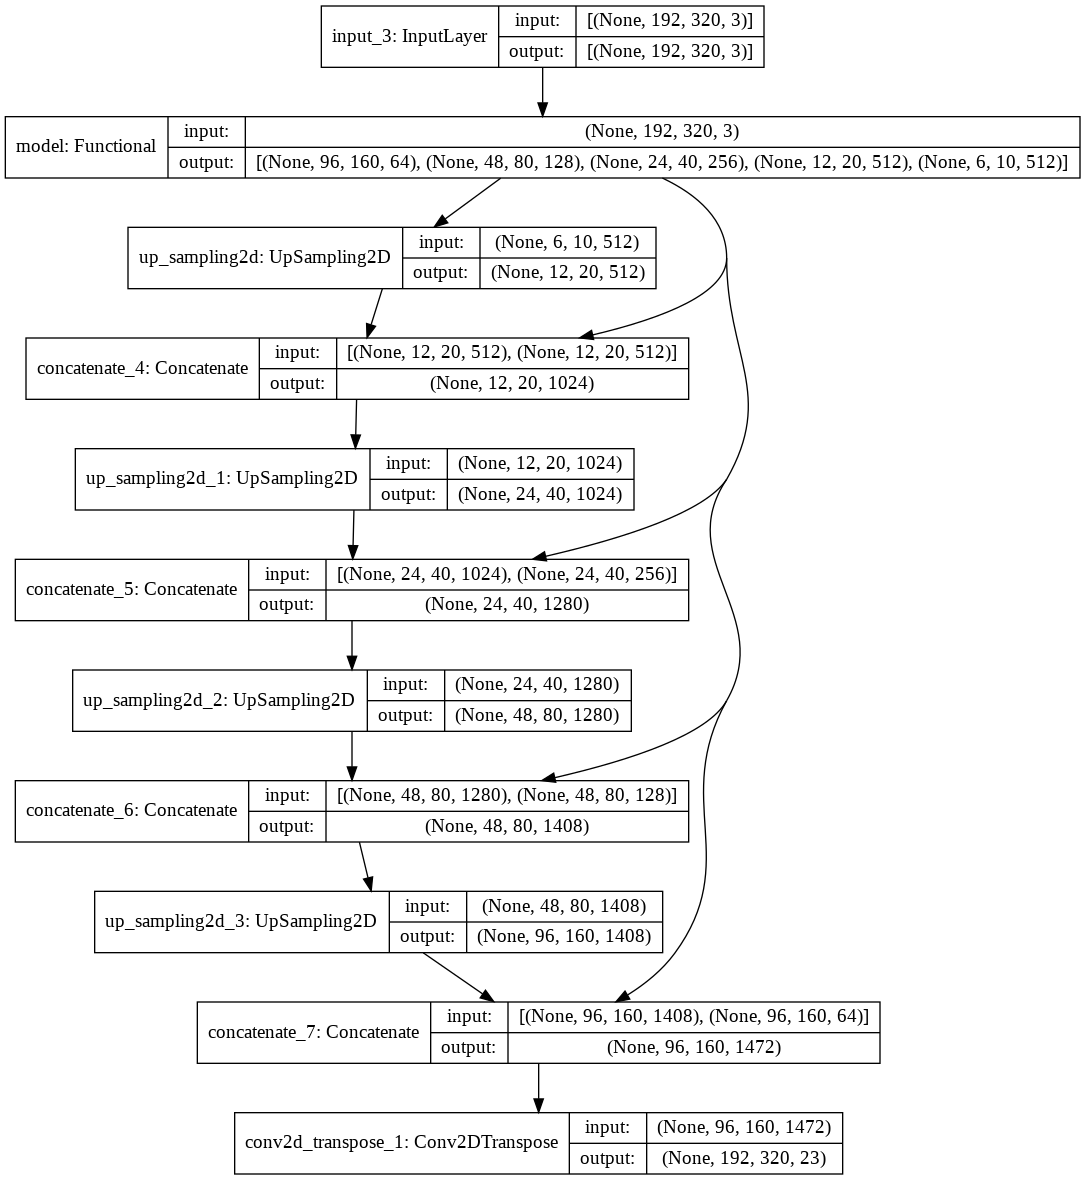

In [86]:
tf.keras.utils.plot_model(segmentation_model, show_shapes=True)